# Data enhancement

We performed STALOC to enhance gene expression patterns on mouse hippocampus datasets. The raw Slide-seq dataset of mouse hippocampus can be accessed through: Single Cell Portal (SCP) accession [SCP815](https://singlecell.broadinstitute.org/single_cell/study/SCP815/highly-sensitive-spatial-transcriptomics-at-near-cellular-resolution-with-slide-seqv2), Puck_200115_08. The raw scRNA-seq dataset of mouse hipocampus can be accessed through: Gene Expression Omnibus (GEO) accession [GSE116470](https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE116470), or [Dropbox](https://www.dropbox.com/s/cs6pii5my4p3ke3/mouse_hippocampus_reference.rds). The down-sampled barcodes and anndata object of processed datasets can be downloaded from [Google Drive](https://drive.google.com/drive/folders/1Qlj8CiplzGBqqbJxh4X97p5JY2WllzEp).

In [1]:
import warnings
warnings.filterwarnings("ignore")
import os
import numpy as np
import pandas as pd
import scanpy as sc
import STALocator
import scipy.sparse as sp

## Read data

In [2]:
# Read ST dataset.
st_data_path = '../data/T4_ST/'
counts_file = os.path.join(st_data_path, 'Puck_200115_08.digital_expression.txt')
coor_file = os.path.join(st_data_path, 'Puck_200115_08_bead_locations.csv')

## Read the expression data.
counts = pd.read_csv(counts_file, sep='\t', index_col=0)

## Read the meta data with spatial location.
coor_df = pd.read_csv(coor_file, sep=",", skiprows=[0], header=None, index_col=0)
coor_df.columns=["xcoord","ycoord"]

## Expression data must be transformed to anndata object, and meta data must be added to it.
adata_ST = sc.AnnData(counts.T)
adata_ST.var_names_make_unique()
coor_df = coor_df.loc[adata_ST.obs_names, ['xcoord', 'ycoord']]
adata_ST.obs[coor_df.columns]=coor_df.loc[coor_df.index, coor_df.columns]
adata_ST.obsm["spatial"] = coor_df.to_numpy()
adata_ST.X=sp.csr_matrix(adata_ST.X)

## Here we only used 10,000 of all beads, the down-sampled barcodes is randomly sampled from all barcoders, 
## you can also down-sample the dataset yourself.
used_barcode = pd.read_csv(os.path.join(st_data_path, 'mh_barcode_down_1w.txt'), sep='\t', header=None)[0]
adata_ST = adata_ST[used_barcode,]
adata_ST.var.index = adata_ST.var.index.str.upper()

In [ ]:
# You can also read the processed h5ad file directly to run the model more easily.
#st_data_path = '../data/T4_ST/'
#adata_ST=sc.read(os.path.join(st_data_path, "mh_slideseq_down_1w.h5ad"))
#adata_ST.var.index = adata_ST.var.index.str.upper()

In [3]:
adata_ST

View of AnnData object with n_obs × n_vars = 10000 × 23264
    obs: 'xcoord', 'ycoord'
    obsm: 'spatial'

In [4]:
# Read scRNA-seq dataset.
sc_data_path="../data/T4_sc/"

## Read the expression data as anndata object.
adata_sc=sc.read_mtx(os.path.join(sc_data_path, "matrix.mtx"))
gene=pd.read_csv(os.path.join(sc_data_path, "genes.tsv"), sep="\t", header=None, index_col=0)
barcode=pd.read_csv(os.path.join(sc_data_path, "barcodes.tsv"), sep="\t", header=None, index_col=0)
adata_sc.var.index=gene.index.values
adata_sc.obs.index=barcode.index.values

## Read the meta data with cell type labels.
meta=pd.read_csv(os.path.join(sc_data_path, "meta.csv"), index_col=0)
meta.index=meta.index.values

## Meta data must be added to the expression data.
adata_sc.obs.loc[meta.index,meta.columns]=meta

## Here we only used 20,000 of all cells, the down-sampled barcodes is randomly sampled from all barcoders, 
## you can also down-sample the dataset yourself.
used_barcode=pd.read_csv(os.path.join(sc_data_path, "mh_barcode_down_2w.txt"), header=None)[0]
adata_sc=adata_sc[used_barcode]

In [ ]:
# You can also read the processed h5ad file directly to run the model more easily.
#sc_data_path="../data/T4_sc/"
#adata_sc=sc.read(os.path.join(sc_data_path, "mh_scRNAseq_down_2w.h5ad"))

In [5]:
adata_sc

View of AnnData object with n_obs × n_vars = 20000 × 27953
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'cluster', 'subcluster', 'celltype', 'class'

In [6]:
sc.pp.filter_genes(adata_ST, min_cells=3)
sc.pp.filter_genes(adata_sc, min_cells=3)

## Run model

In [7]:
experiment_path="T4"
if not os.path.exists(experiment_path):
    os.makedirs(experiment_path)

In [8]:
model = STALocator.model.Model(resolution="high", batch_size=200, train_epoch=5000, seed=1234, lambdacos=15, lambdaSWD = 2, 
                               model_path = "T4/models", data_path = "T4/data", result_path = "T4/results", device="cuda:0")

In [9]:
model.preprocess(adata_sc, adata_ST)

Finding highly variable genes...
Normalizing and scaling...
Dimensionality reduction via PCA...


In [10]:
model.train(metric="cosine", reg=0.1, numItermax=10)

Begining time:  Sun Mar 10 15:01:20 2024
step 0, total_loss=451.0260, loss_D=9.3941, loss_GAN=2.9571, loss_AE=23.0029, loss_cos=2.0129, loss_LA=17.4797, loss_SWD=6.5250
step 500, total_loss=18.8608, loss_D=1.2947, loss_GAN=5.9270, loss_AE=0.6476, loss_cos=0.2811, loss_LA=0.1343, loss_SWD=0.4496
step 1000, total_loss=16.9218, loss_D=1.4653, loss_GAN=6.4743, loss_AE=0.5044, loss_cos=0.2478, loss_LA=0.0909, loss_SWD=0.3883
step 1500, total_loss=14.2508, loss_D=1.2561, loss_GAN=5.5995, loss_AE=0.4031, loss_cos=0.2390, loss_LA=0.0569, loss_SWD=0.2333
step 2000, total_loss=14.9940, loss_D=1.0405, loss_GAN=6.1425, loss_AE=0.4338, loss_cos=0.2410, loss_LA=0.0473, loss_SWD=0.2128
step 2500, total_loss=14.5288, loss_D=1.1409, loss_GAN=6.5290, loss_AE=0.3718, loss_cos=0.2302, loss_LA=0.0412, loss_SWD=0.2084
step 3000, total_loss=14.4065, loss_D=1.2047, loss_GAN=6.2288, loss_AE=0.3828, loss_cos=0.2397, loss_LA=0.0402, loss_SWD=0.1760
step 3500, total_loss=14.2583, loss_D=0.8005, loss_GAN=6.6806, l

In [11]:
model.eval(retain_prop=0.1)

Enhanced ST dataset has been saved!


In [12]:
adata_total = model.adata_total
adata_sc = model.adata_A_input
adata_ST = model.adata_B_input
adata_ST_pm = model.adata_ST_pm

In [13]:
adata_ST_pm

AnnData object with n_obs × n_vars = 10000 × 21370
    obs: 'xcoord', 'ycoord', 'batch'
    var: 'n_cells', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm'
    obsm: 'spatial'

## Visualization of data enhancement results

In [14]:
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
N = 256
vals = np.ones((N, 4))
vals[:, 0] = np.linspace(0.9, 0.24705882, N)
vals[:, 1] = np.linspace(0.9, 0, N)
vals[:, 2] = np.linspace(0.9, 0.49019608, N)
newcmp = ListedColormap(vals)

In [15]:
show_gene1=["ITPKA","AMIGO2","HS3ST4","CALB1","OLIG1","GFAP"]
show_gene2=["NEUROD1","OLIG2","ACTA2"]

[<AxesSubplot:title={'center':'ITPKA'}, xlabel='spatial1', ylabel='spatial2'>,
 <AxesSubplot:title={'center':'AMIGO2'}, xlabel='spatial1', ylabel='spatial2'>,
 <AxesSubplot:title={'center':'HS3ST4'}, xlabel='spatial1', ylabel='spatial2'>,
 <AxesSubplot:title={'center':'CALB1'}, xlabel='spatial1', ylabel='spatial2'>,
 <AxesSubplot:title={'center':'OLIG1'}, xlabel='spatial1', ylabel='spatial2'>,
 <AxesSubplot:title={'center':'GFAP'}, xlabel='spatial1', ylabel='spatial2'>]

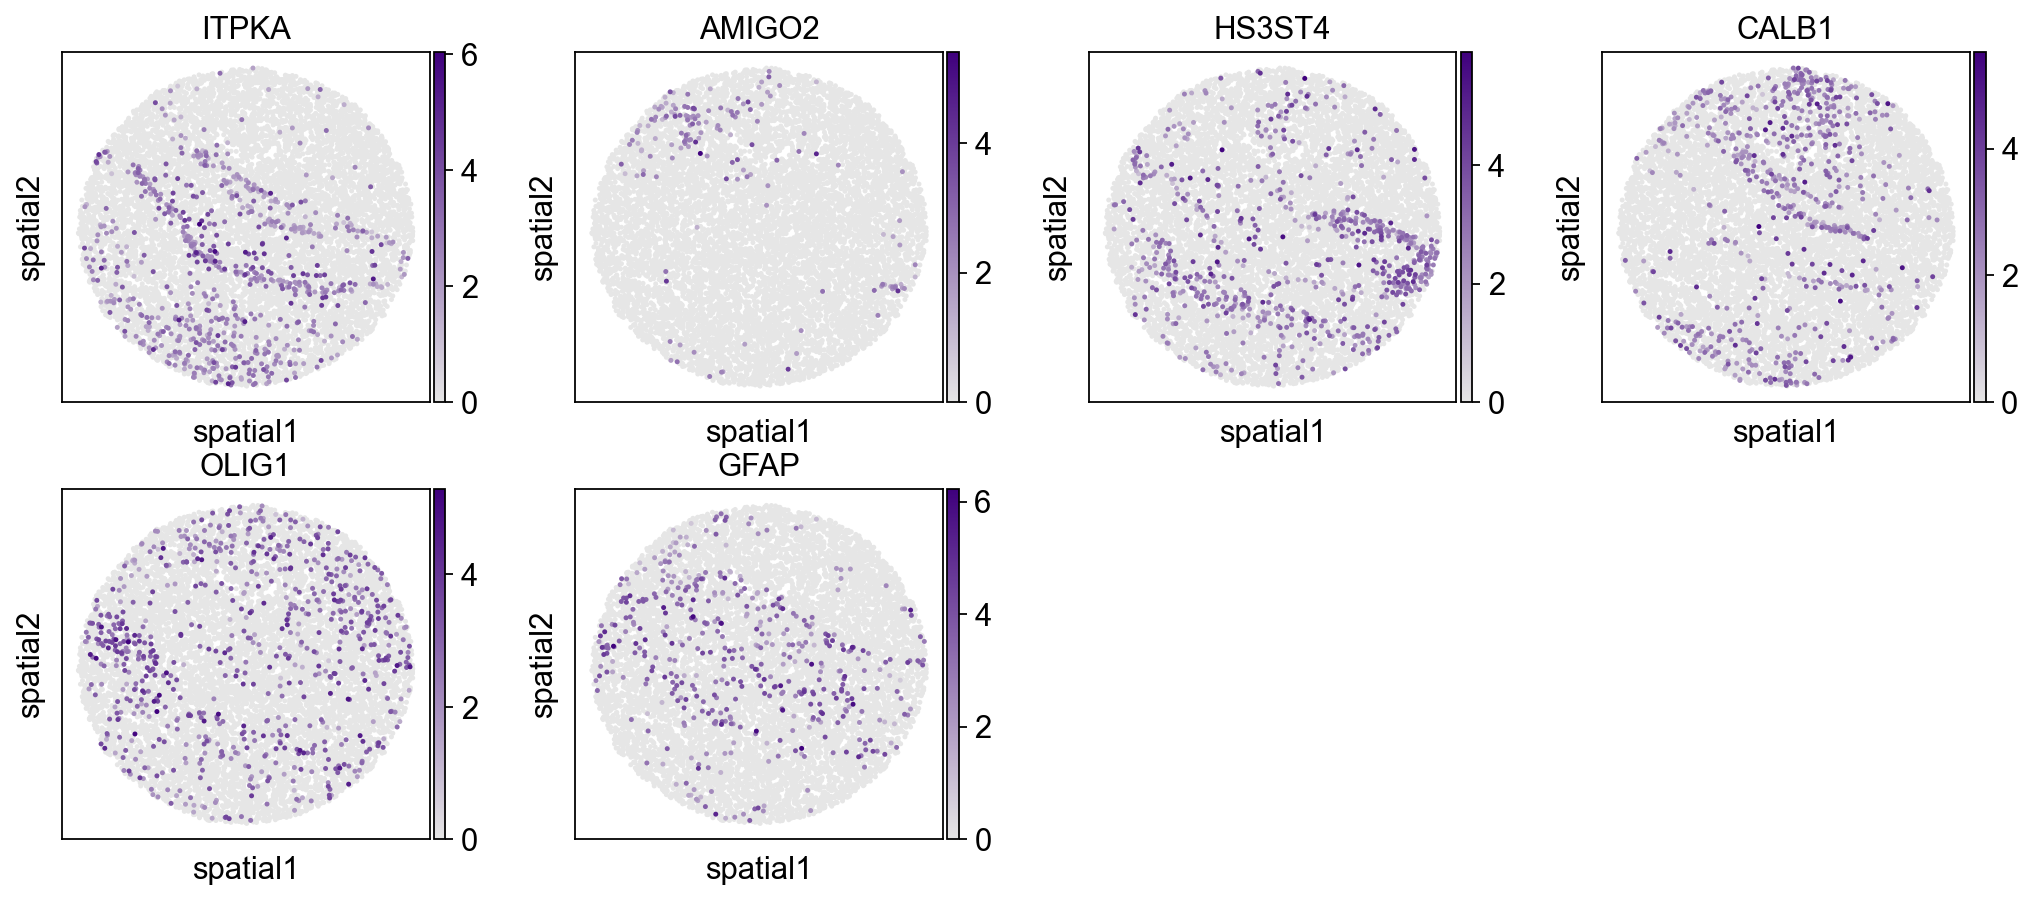

In [17]:
sc.set_figure_params(dpi=80, figsize=(3, 3))
sc.pl.embedding(adata_ST, basis='spatial', color=show_gene1, color_map=newcmp, s=20, show=False)

[<AxesSubplot:title={'center':'ITPKA'}, xlabel='spatial1', ylabel='spatial2'>,
 <AxesSubplot:title={'center':'AMIGO2'}, xlabel='spatial1', ylabel='spatial2'>,
 <AxesSubplot:title={'center':'HS3ST4'}, xlabel='spatial1', ylabel='spatial2'>,
 <AxesSubplot:title={'center':'CALB1'}, xlabel='spatial1', ylabel='spatial2'>,
 <AxesSubplot:title={'center':'OLIG1'}, xlabel='spatial1', ylabel='spatial2'>,
 <AxesSubplot:title={'center':'GFAP'}, xlabel='spatial1', ylabel='spatial2'>]

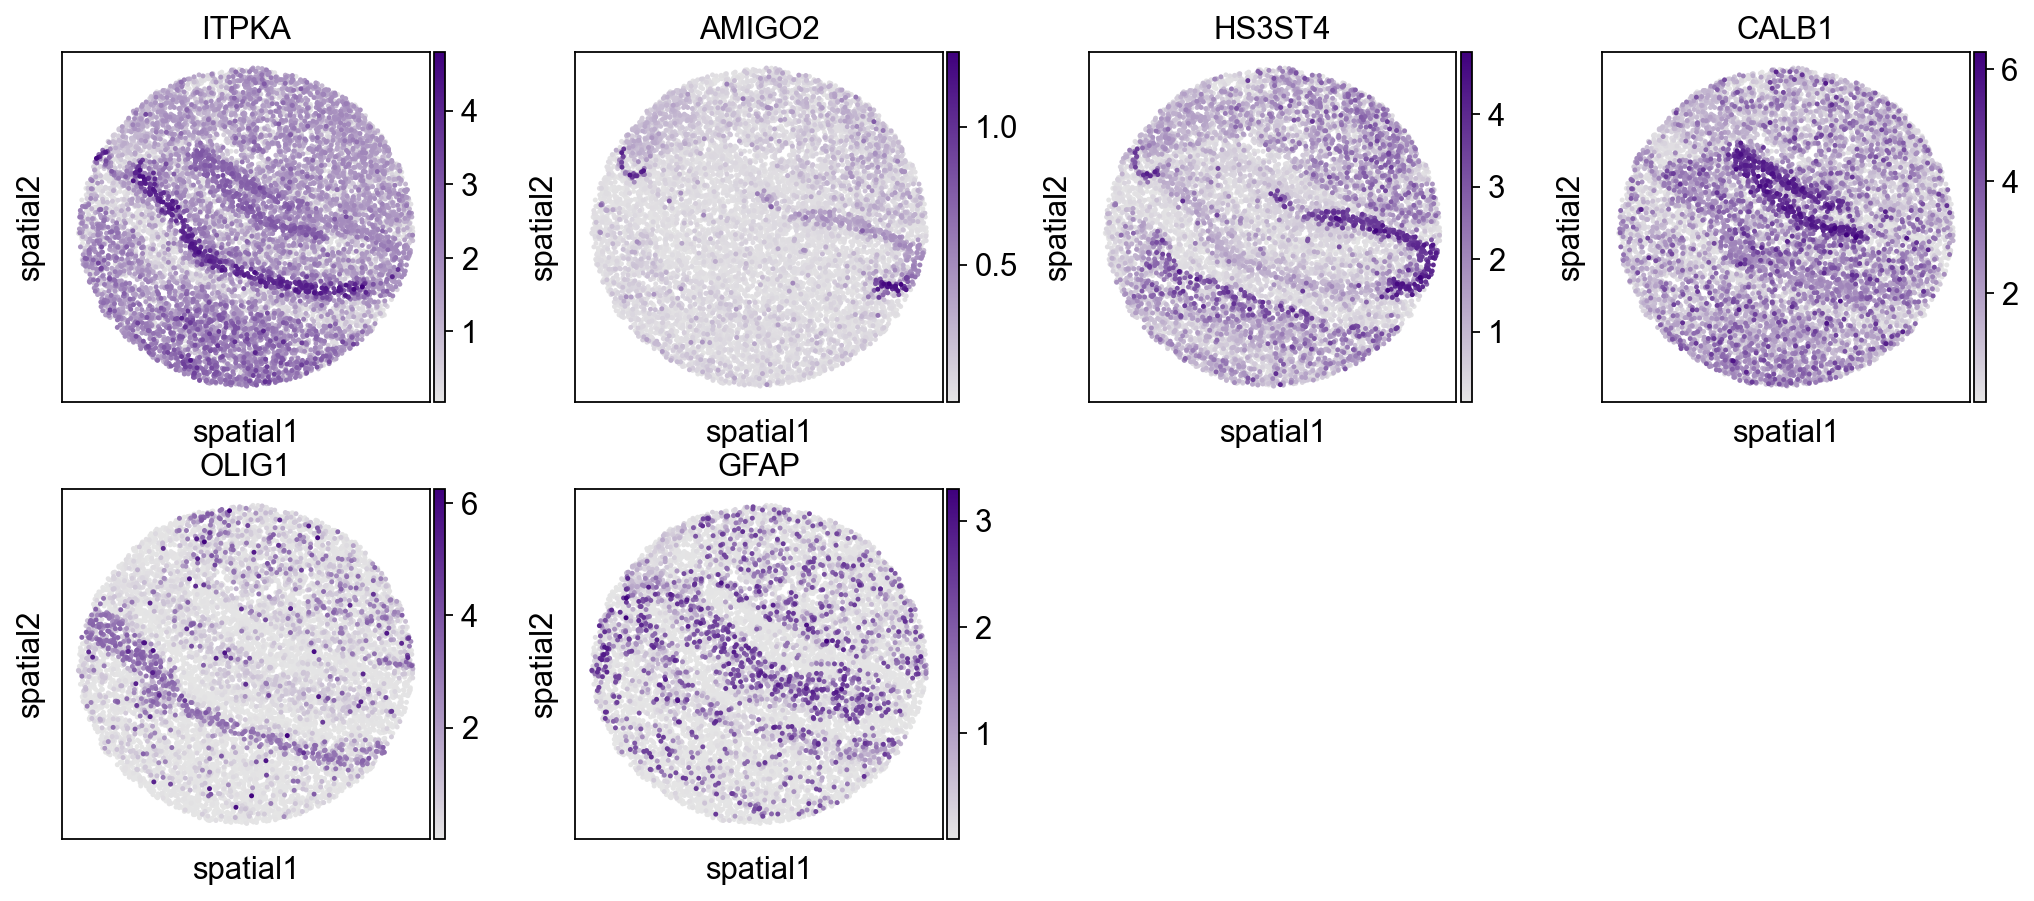

In [18]:
sc.set_figure_params(dpi=80, figsize=(3, 3))
sc.pl.embedding(adata_ST_pm, basis="spatial", color=show_gene1, color_map=newcmp, s=20, show=False)

[<AxesSubplot:title={'center':'NEUROD1'}, xlabel='spatial1', ylabel='spatial2'>,
 <AxesSubplot:title={'center':'OLIG2'}, xlabel='spatial1', ylabel='spatial2'>,
 <AxesSubplot:title={'center':'ACTA2'}, xlabel='spatial1', ylabel='spatial2'>]

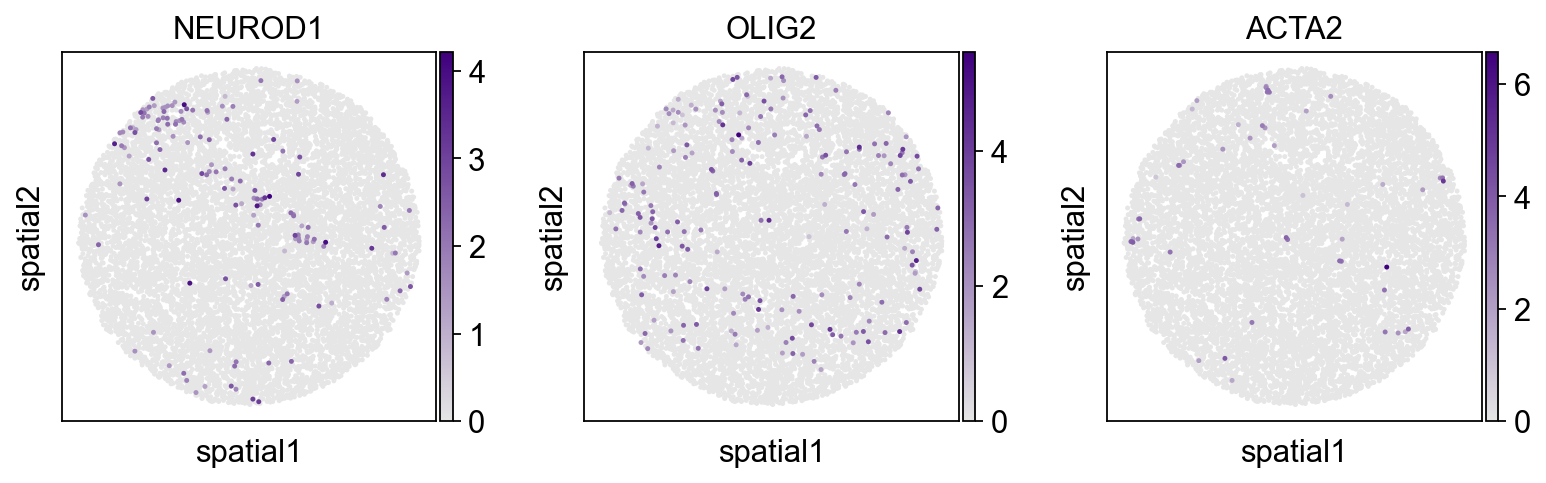

In [19]:
sc.set_figure_params(dpi=80, figsize=(3, 3))
sc.pl.embedding(adata_ST, basis='spatial', color=show_gene2, color_map=newcmp, s=20, show=False)

[<AxesSubplot:title={'center':'NEUROD1'}, xlabel='spatial1', ylabel='spatial2'>,
 <AxesSubplot:title={'center':'OLIG2'}, xlabel='spatial1', ylabel='spatial2'>,
 <AxesSubplot:title={'center':'ACTA2'}, xlabel='spatial1', ylabel='spatial2'>]

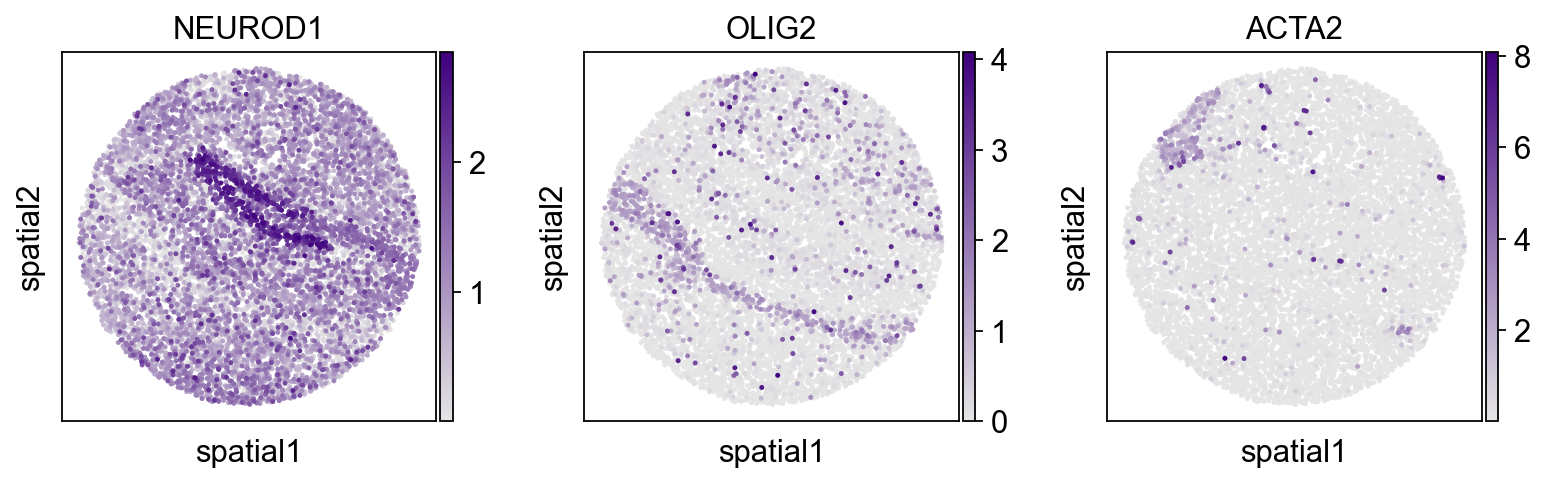

In [20]:
sc.set_figure_params(dpi=80, figsize=(3, 3))
sc.pl.embedding(adata_ST_pm, basis="spatial", color=show_gene2, color_map=newcmp, s=20, show=False)

## Label transfer

In [21]:
trans_label=model.trans_label

In [22]:
adata_ST.obs.loc[trans_label.index, trans_label.columns]=trans_label

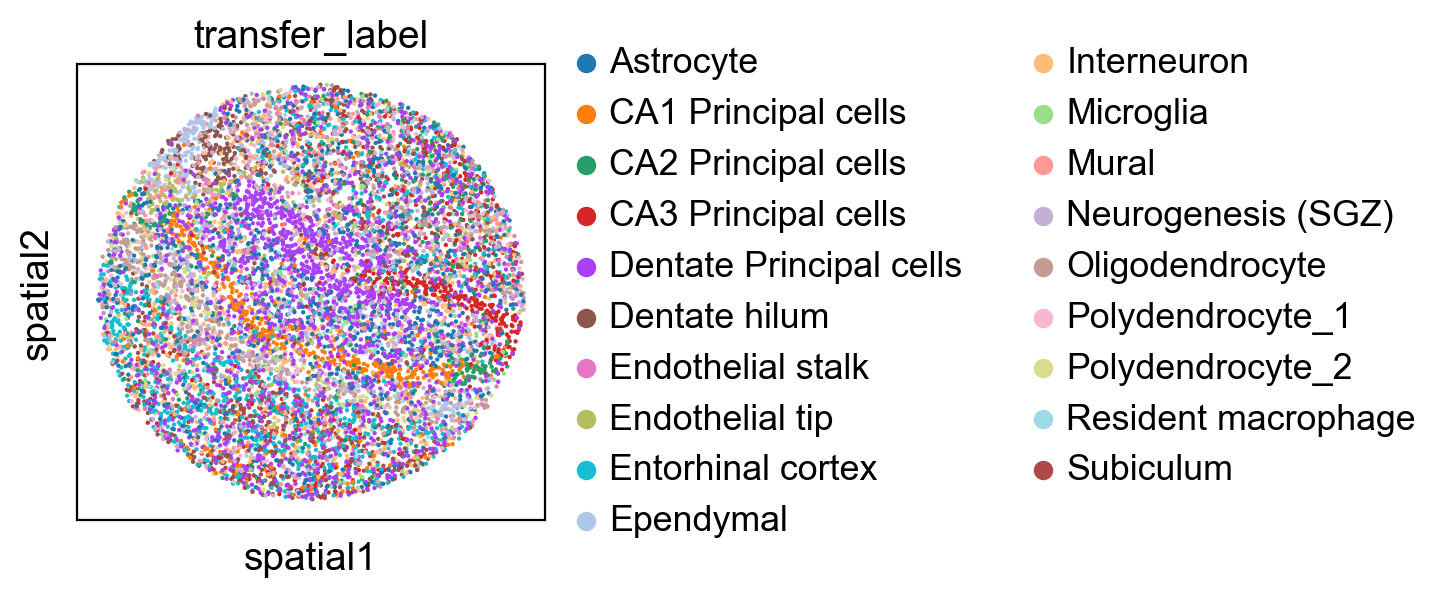

In [23]:
sc.set_figure_params(dpi=100, figsize=(3, 3))
sc.pl.embedding(adata_ST, basis="spatial", color="transfer_label", s=10)

## Identifying spatially variable genes (SVGs)

This part needs [Hotspot](https://github.com/Yoseflab/Hotspot) package.

In [24]:
import hotspot
import matplotlib.pyplot as plt
import matplotlib.colors
import seaborn as sns
from tqdm import tqdm
from matplotlib_venn import venn2, venn2_circles

In [25]:
sc.pp.filter_genes(adata_ST, min_cells=1)
print('After flitering: ', adata_ST.shape)

After flitering:  (10000, 17010)


In [26]:
sc.pp.filter_genes(adata_ST_pm, min_cells=1)
print('After flitering: ', adata_ST_pm.shape)

After flitering:  (10000, 21370)


In [27]:
adata_ST.X=sp.csc_matrix(adata_ST.X)
adata_ST_pm.X=sp.csc_matrix(adata_ST_pm.X)

In [28]:
hs = hotspot.Hotspot(adata_ST,model='none',latent_obsm_key="spatial")
hs.create_knn_graph(weighted_graph=False, n_neighbors=30)
hs_results = hs.compute_autocorrelations()
hs_genes = hs_results.loc[hs_results.FDR < 0.001].index

100%|██████████████████████████████████████████████████████████████████████████| 17010/17010 [00:12<00:00, 1329.01it/s]


In [29]:
hs_staloc = hotspot.Hotspot(adata_ST_pm,model='none',latent_obsm_key="spatial")
hs_staloc.create_knn_graph(weighted_graph=False, n_neighbors=30)
hs_staloc_results = hs_staloc.compute_autocorrelations()
hs_staloc_genes = hs_staloc_results.loc[hs_staloc_results.FDR < 0.001].index

100%|███████████████████████████████████████████████████████████████████████████| 21370/21370 [00:40<00:00, 532.63it/s]


In [30]:
hs_results.to_csv("T4/results/hotspot_results_raw.csv")
hs_staloc_results.to_csv("T4/results/hotspot_results_staloc.csv")

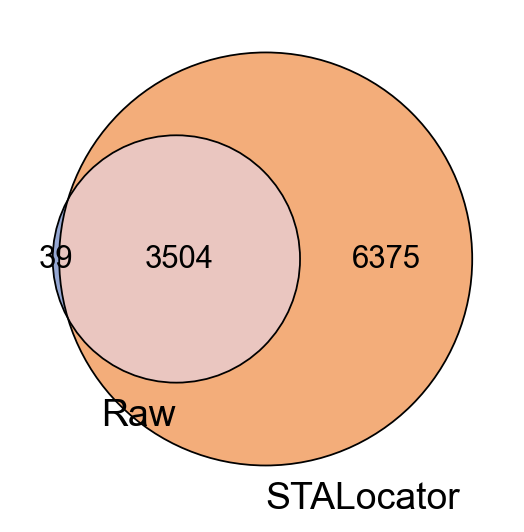

In [31]:
sc.set_figure_params(dpi=80, figsize=(4, 4))
g=venn2(subsets = [set(hs_genes), set(hs_staloc_genes)], set_labels = ["Raw","STALocator"],
        set_colors=("#4f6db4", "#ec7722"), alpha=0.6, normalize_to=1.0)
g=venn2_circles(subsets = [set(hs_genes), set(hs_staloc_genes)], linewidth=0.8, color="black")
plt.show()

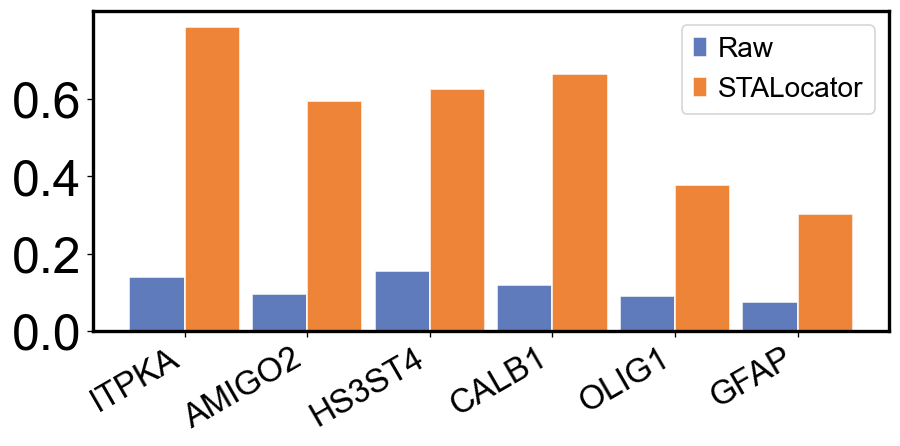

In [32]:
sc.set_figure_params(dpi=60, figsize=(8.5, 3.5))
n = len(show_gene1)
X = np.arange(n)+1
Y1 = hs_results.loc[show_gene1,"C"]
Y2 = hs_staloc_results.loc[show_gene1,"C"]
plt.bar(X, Y1, alpha=0.9, width = 0.45, facecolor = '#4f6db4', edgecolor = 'white', label='Raw', lw=1)
plt.bar(X+0.45, Y2, alpha=0.9, width = 0.45, facecolor = '#ec7722', edgecolor = 'white', label='STALocator', lw=1)
plt.legend(loc="upper right", fontsize = "large")
plt.grid(False)
plt.title('')
plt.xlabel('')
plt.ylabel('')
plt.xticks(X+0.225, show_gene1, rotation=30, fontsize=20, ha="right")
#plt.xticks([])
plt.yticks(size=30)
plt.yticks([0,0.2,0.4,0.6])
ax = plt.gca()
for spine in ax.spines.values():
    spine.set_edgecolor('black')
    spine.set_linewidth(2)
#plt.savefig("../../figures/T4_C_gene1.png", bbox_inches='tight')
plt.show()

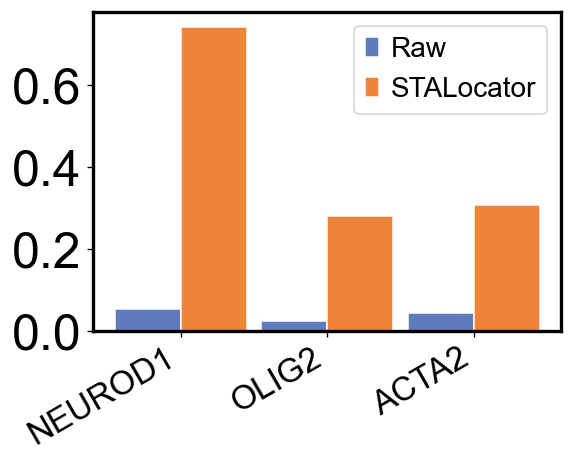

In [33]:
sc.set_figure_params(dpi=60, figsize=(5, 3.5))
n = len(show_gene2)
X = np.arange(n)+1
Y1 = hs_results.loc[show_gene2,"C"]
Y2 = hs_staloc_results.loc[show_gene2,"C"]
plt.bar(X, Y1, alpha=0.9, width = 0.45, facecolor = '#4f6db4', edgecolor = 'white', label='Raw', lw=1)
plt.bar(X+0.45, Y2, alpha=0.9, width = 0.45, facecolor = '#ec7722', edgecolor = 'white', label='STALocator', lw=1)
plt.legend(loc="upper right", fontsize = "large")
plt.grid(False)
plt.title('')
plt.xlabel('')
plt.ylabel('')
plt.xticks(X+0.225, show_gene2, rotation=30, fontsize=20, ha="right")
#plt.xticks([])
plt.yticks(size=30)
plt.yticks([0,0.2,0.4,0.6])
ax = plt.gca()
for spine in ax.spines.values():
    spine.set_edgecolor('black')
    spine.set_linewidth(2)
#plt.savefig("../../figures/T4_C_gene2.png", bbox_inches='tight')
plt.show()

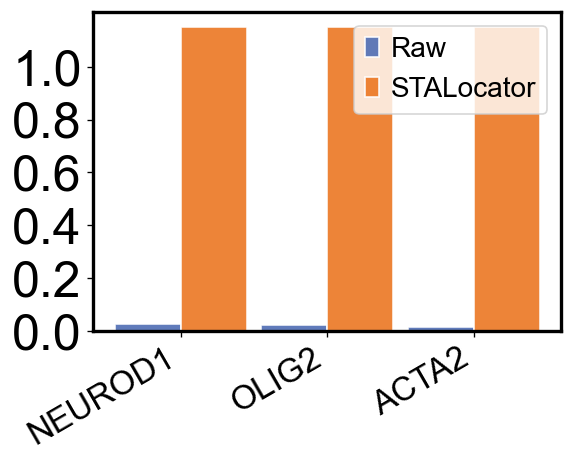

In [34]:
sc.set_figure_params(dpi=60, figsize=(5, 3.5))
n = len(show_gene2)
X = np.arange(n)+1
Y1 = -np.log(hs_results.loc[show_gene2,"Pval"])/100
Y2 = -np.log(hs_staloc_results.loc[show_gene2,"Pval"]+1e-50)/100
plt.bar(X, Y1, alpha=0.9, width = 0.45, facecolor = '#4f6db4', edgecolor = 'white', label='Raw', lw=1)
plt.bar(X+0.45, Y2, alpha=0.9, width = 0.45, facecolor = '#ec7722', edgecolor = 'white', label='STALocator', lw=1)
plt.legend(loc="upper right", fontsize = "large")
plt.grid(False)
plt.title('')
plt.xlabel('')
plt.ylabel('')
plt.xticks(X+0.225, show_gene2, rotation=30, fontsize=20, ha="right")
#plt.xticks([])
plt.yticks(size=30)
plt.yticks([0,0.2,0.4,0.6,0.8,1])
ax = plt.gca()
for spine in ax.spines.values():
    spine.set_edgecolor('black')
    spine.set_linewidth(2)
#plt.savefig("../../figures/T4_FDR_gene2.png", bbox_inches='tight')
plt.show()